In [66]:
import wave #for getting the wav file
import matplotlib.pyplot as plt #for plotting
import librosa #for doing all of the wavestuff
import numpy as np #vector stuff
import pandas as pd #dataframe
import torch #tesnor storage of the matrix data


load the wav file

In [67]:
file_path = 'testfile.wav'
#use the path to any of the audio files to see how the features look

with wave.open(file_path, 'rb') as wav_file: #read only
    # Read audio frames and get parameters.
    audio_data = wav_file.readframes(wav_file.getnframes())
    params = wav_file.getparams()
print(params)
print(type(audio_data), len(audio_data))

_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=40879, comptype='NONE', compname='not compressed')
<class 'bytes'> 81758


In [68]:
#do it in librosa
audio_data, sample_rate = librosa.load(file_path, sr=None)
pts = len(audio_data)
secs = pts/sample_rate
print(sample_rate, pts, secs)

16000 40879 2.5549375


Look at the waveplot

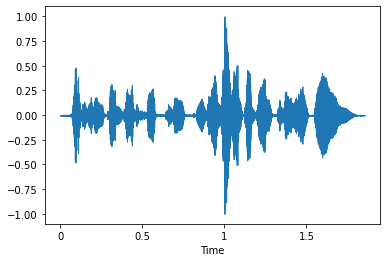

In [69]:
librosa.display.waveshow(audio_data)

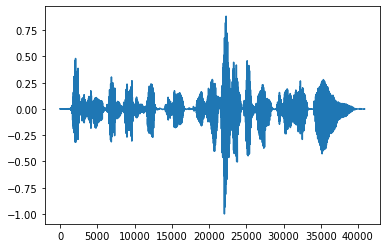

In [70]:
#regular plotting does a much better job on some files
plt.plot(audio_data)
plt.show()

Get amplitude info: max, min, avg

In [71]:
def get_mMa(clip):
    max_amp = np.max(clip)
    min_amp = np.min(clip)
    mean_amp = np.mean(clip) 
    med_amp = np.median(clip)
    return max_amp, min_amp, mean_amp, med_amp

In [72]:
mMmm = get_mMa(audio_data)
print(mMmm)
#matches the graph from matplotlib, which is more accurate than the librosa one

(0.88339233, -0.9999695, -0.0001630573, 0.00024414062)


Split the waveplot into sections and get data for each

In [73]:
n = 6 #number of sections to split into +1
#the shortest filess are 1 second and we don't want clips shorter than 200 ms since that's what the human ear picks up
pps = np.round(pts/n) #points per section, with the last section getting the extras or shorted
cutoffs = [int(pps * i) for i in range(0, n-1)]
cutoffs.append(int(pts))

In [74]:
segsum = []
for i in range(0, n-1):
    shortclip = audio_data[cutoffs[i]:cutoffs[i+1]]
    clipdata= get_mMa(shortclip)
    segsum.append(clipdata)

In [75]:
#raw info for each of the segnments
summary = torch.tensor(segsum) #columns: "max", "min", "mean", "med"

Add comparisons to "normalize" the amplitudes to a baseline

In [76]:
#overall stats
peak = max(mMmm[0], np.abs(mMmm[1]))
totmean = mMmm[2]
totmed = mMmm[3]

#make tensor of the overall stats
peakt = torch.full((n-1, 2), peak)
meant = torch.full((n-1, 1), totmean)
medt = torch.full((n-1, 1), totmed)

basest = torch.cat((peakt, meant, medt), dim=1) 

In [78]:
#Make new columns that are normalized
normt = summary/basest

#add them to the tensor
combot = torch.cat((summary, normt), dim=1) 
#print(outtensor.shape, outtensor)

Find the gradient/differences

In [79]:
#to compare easily, make a new tensor that is the old one shifted. For sizing, need to make the original one line bigger as well
zerost = torch.zeros(1, 8)
lastt = torch.cat((combot, zerost), dim=0)
nextt = torch.cat((zerost, combot), dim=0)
diffs = nextt-lastt
grads = nextt/lastt #need to replace nans with 0s


In [80]:
#remove the last line since it doesn't have meaning and attach to the original summary to have something to return
tensoroutput = torch.cat((combot, diffs[0:n-1], grads[0:n-1]), dim=1)
#columns: 1: max, 2: min, 3: mean, 4: med, 5: normalized max, 6: normalized min, 
#7: normalized mean, 8: normalized med, 9-16: raw difference between steps of first 8 columns,
#17-24: % difference between steps of first 8 columns

#print(combot.shape, tensoroutput.shape)

torch.Size([5, 8]) torch.Size([5, 24])


Let's plot the everything to make sure that it makes sense

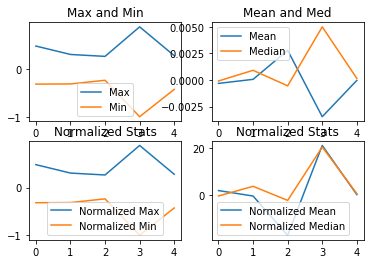

In [81]:
#stats and normalized stats
maxs = tensoroutput[:, 0]
mins = tensoroutput[:, 1]
means = tensoroutput[:, 2]
meds = tensoroutput[:, 3]
nmaxs = tensoroutput[:, 4]
nmins = tensoroutput[:, 5]
nmeans = tensoroutput[:, 6]
nmeds = tensoroutput[:, 7]


plt.subplot(2, 2, 1)  # (rows, columns, index)
plt.plot(maxs, label='Max')
plt.plot(mins, label='Min')
plt.title('Max and Min')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(means, label='Mean')
plt.plot(meds, label='Median')
plt.title('Mean and Med')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(nmaxs, label='Normalized Max')
plt.plot(nmins, label='Normalized Min')
plt.title('Normalized Stats')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(nmeans, label='Normalized Mean')
plt.plot(nmeds, label='Normalized Median')
plt.title('Normalized Stats')
plt.legend()

plt.show()

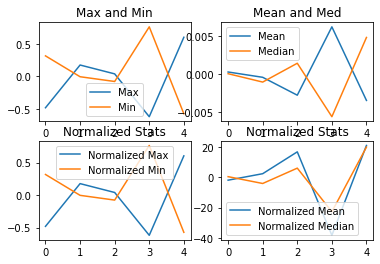

In [82]:
#changes and normalized changes
deltamaxs = tensoroutput[:, 8]
deltamins = tensoroutput[:, 9]
deltameans = tensoroutput[:, 10]
deltameds = tensoroutput[:, 11]
deltanmaxs = tensoroutput[:, 12]
deltanmins = tensoroutput[:, 13]
deltanmeans = tensoroutput[:, 14]
deltanmeds = tensoroutput[:, 15]


plt.subplot(2, 2, 1)  # (rows, columns, index)
plt.plot(deltamaxs, label='Max')
plt.plot(deltamins, label='Min')
plt.title('Max and Min')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(deltameans, label='Mean')
plt.plot(deltameds, label='Median')
plt.title('Mean and Med')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(deltanmaxs, label='Normalized Max')
plt.plot(deltanmins, label='Normalized Min')
plt.title('Normalized Stats')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(deltanmeans, label='Normalized Mean')
plt.plot(deltanmeds, label='Normalized Median')
plt.title('Normalized Stats')
plt.legend()

plt.show()


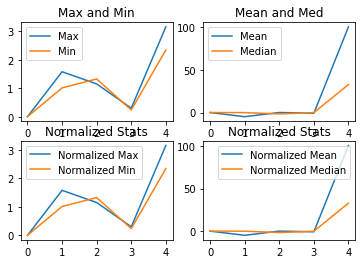

In [83]:
#changes and normalized changes
pctmaxs = tensoroutput[:, 16]
pctmins = tensoroutput[:, 17]
pctmeans = tensoroutput[:, 18]
pctmeds = tensoroutput[:, 19]
pctnmaxs = tensoroutput[:, 20]
pctnmins = tensoroutput[:, 21]
pctnmeans = tensoroutput[:, 22]
pctnmeds = tensoroutput[:, 23]


plt.subplot(2, 2, 1)  # (rows, columns, index)
plt.plot(pctmaxs, label='Max')
plt.plot(pctmins, label='Min')
plt.title('Max and Min')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(pctmeans, label='Mean')
plt.plot(pctmeds, label='Median')
plt.title('Mean and Med')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(pctnmaxs, label='Normalized Max')
plt.plot(pctnmins, label='Normalized Min')
plt.title('Normalized Stats')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(pctnmeans, label='Normalized Mean')
plt.plot(pctnmeds, label='Normalized Median')
plt.title('Normalized Stats')
plt.legend()

plt.show()


To compare with others, return the overall averages as well as the tensor of segments

In [84]:
energy = (mMmm, tensoroutput)
